In [295]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.mappings import PT_value_mapping
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping


In [296]:
scale_comp = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='ScaleComp')
pt_dat = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='PTdat')
polities_df = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='polities')

In [297]:
# pt_dat['Scale'] = np.nan
# pt_dat['Comp'] = np.nan

# row = pt_dat.iloc[0]

# for index,row in pt_dat.iterrows():
#     scale_comp_pol = scale_comp[scale_comp.PolID == row.PolID]
#     if len(scale_comp_pol) == 0:
#         pass
#     elif len(scale_comp_pol) == 1:
#         pt_dat.loc[index,'Scale'] = scale_comp_pol['Scale'].values[0]
#         pt_dat.loc[index,'Comp'] = scale_comp_pol['Comp'].values[0]

#     elif len(scale_comp_pol) > 1:
#         years = scale_comp_pol['Time'].values
#         # find closest year before row.year
#         years_before = years[years < row.year]
#         if len(years_before) == 0:
#             closest_year = years[0]
#         else:
#             closest_year = years_before[np.argmax(years_before)]
#         closest_year_row = scale_comp_pol[scale_comp_pol.Time == closest_year]
#         pt_dat.loc[index,'Scale'] = closest_year_row['Scale'].values[0]
#         pt_dat.loc[index,'Comp'] = closest_year_row['Comp'].values[0]

In [298]:
pt_dat.dropna(subset=['Scale','Comp', 'assassin'], inplace=True)

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_84806/158055537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_plot.dropna(subset=['Scale','Comp','assassin'],inplace=True)


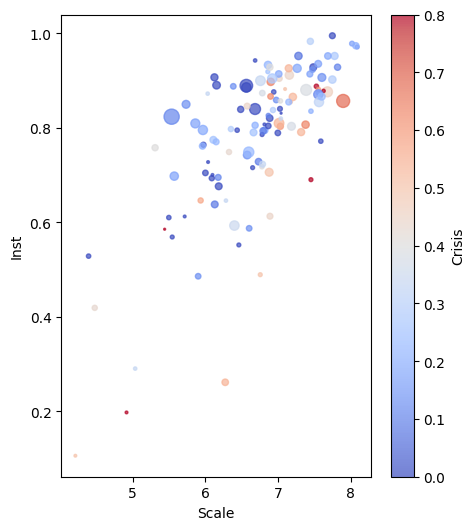

In [299]:
dataset_plot = pt_dat[['PolID','Scale','Comp','year']+['assassin']]
dataset_plot.dropna(subset=['Scale','Comp','assassin'],inplace=True)
polity_group = dataset_plot.groupby('PolID')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale'].mean()
mean_crisis = polity_group['assassin'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]


v_max = mean_crisis.max()*0.8
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()

In [300]:
import statsmodels.api as sm

x_cols = ['Scale','Comp']
y_col = 'assassin'
Xy = pt_dat[[y_col]+x_cols].dropna()
Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col].apply(int)

# linear_model = sm.OLS(y, X)
# result = linear_model.fit()

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
# print pvalues
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.526796
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               assassin   No. Observations:                 1349
Model:                          Logit   Df Residuals:                     1346
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Jan 2025   Pseudo R-squ.:                 0.04882
Time:                        13:38:56   Log-Likelihood:                -710.65
converged:                       True   LL-Null:                       -747.12
Covariance Type:            nonrobust   LLR p-value:                 1.446e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Scale          0.9609      0.122      7.871      0.000       0.722       1.200
Comp          -3.9746      0.

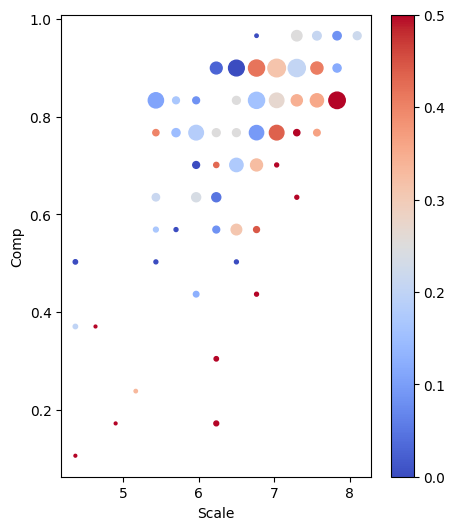

In [301]:
x_cols = ['Scale','Comp']
y_col = 'assassin'
Xy = pt_dat[[y_col]+x_cols].dropna()

x = Xy["Scale"].values
y = Xy["Comp"].values
z = Xy["assassin"].values

grid_size = 15

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()

fig, ax = plt.subplots(figsize=(5, 6))
x,y = np.meshgrid(x_bins, y_bins)
plt.scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=counts.T.values.flatten()*2, vmax = 0.5)
plt.colorbar()
plt.xlabel('Scale')
plt.ylabel('Comp')
# plt.title(crisis_vars)
plt.show()

In [302]:
import statsmodels.api as sm

x_cols = ['Scale','Comp']
y_col = 'assassin'
Xy = pt_dat[[y_col]+x_cols].dropna()
Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col].apply(int)

linear_model = sm.OLS(y, X)
result = linear_model.fit()

# print(result.summary())
# result = logit_model.fit()


In [303]:
# list sheets of xls file
xl = pd.ExcelFile('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx')
print(xl.sheet_names)
# import TSDat1 sheet
tsdat1 = xl.parse('TSDat1')
tsdat1 = pd.read_csv('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/TSDat1.csv')
tsdat1.iloc[:, 4:-2] = tsdat1.iloc[:, 4:-1].applymap(lambda x: np.nan if x == -999 else x)
variable_names = xl.parse('variables')
# create dict out of ShortName and Polaris_var columns
variable_dict = dict(zip(variable_names.ShortName,variable_names.Polaris_var))
variable_dict['PolID'] = 'PolityName'
variable_dict['Time'] = 'Year'
tsdat1.rename(columns=variable_dict,inplace=True)
tsdat1.columns

['polities', 'variables', 'TSDat1', 'Religion', 'AggrDat', 'ImpSCDat', 'ScaleComp', 'PTdat']


Index(['NGA', 'PolityName', 'Year', 'PropCoded', 'polity_population',
       'polity_territory', 'population_of_the_largest_settlement',
       'administrative_level', 'military_level', 'religious_level',
       'settlement_hierarchy', 'professional_military_officer',
       'professional_soldier', 'professional_priesthood',
       'full_time_bureaucrat', 'examination_system', 'merit_promotion',
       'specialized_government_building', 'court', 'formal_legal_code',
       'judge', 'professional_lawyer', 'irrigation_system',
       'drinking_water_supply_system', 'market', 'food_storage_site', 'road',
       'bridge', 'canal', 'port', 'mines_or_quarry', 'courier',
       'postal_station', 'general_postal_service', 'mnemonic_device',
       'nonwritten_record', 'written_record', 'script', 'non_phonetic_writing',
       'phonetic_alphabetic_writing', 'lists_tables_and_classification',
       'calendar', 'sacred_text', 'religious_literature',
       'practical_literature', 'history', 'phi

In [304]:
# list sheets of xls file
xl = pd.ExcelFile('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx')
print(xl.sheet_names)
# import TSDat1 sheet
tsdat1 = xl.parse('TSDat1')
tsdat1 = pd.read_csv('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/TSDat1.csv')
tsdat1.iloc[:, 4:-2] = tsdat1.iloc[:, 4:-1].applymap(lambda x: np.nan if x == -999 else x)
variable_names = xl.parse('variables')
# create dict out of ShortName and Polaris_var columns
variable_dict = dict(zip(variable_names.ShortName,variable_names.Polaris_var))
variable_dict['PolID'] = 'PolityName'
variable_dict['Time'] = 'Year'
tsdat1.rename(columns=variable_dict,inplace=True)

new_keys = {'polity_population':'polity-populations', 
                                  'polity_territory':'polity-territories', 
                                  'population_of_the_largest_settlement':'population-of-the-largest-settlements',
                                  'administrative_level':'administrative-levels',
                                  'military_level':'military-levels',
                                  'religious_level':'religious-levels',
                                  'settlement_hierarchy':'settlement-hierarchies',
                                  'professional_priesthood':'professional-priesthoods',
                                  'examination_system':'examination-systems',
                                  'formal_legal-code':'formal-legal-codes',
                                  'drinking_water_supply_system':'drinking-water-supplies',
                                  'script':'scripts',
                                  'phonetic_alphabetic_writing':'phonetic-alphabetic-writings',
                                  'non_phonetic_writing':'non-phonetic-writings',
                                  'calendar':'calendars',
                                  'scientific_literature':'scientific-literatures',
                                  'history':'histories',
                                  'fiction':'fictions',
                                  'practical-literature':'practical-literatures',
                                  'philosophy':'philosophies',
                                  'paper_currency':'paper-currencies',
                                  'professional_military_officer':'professional-military-officers',
                                  'professional_soldier':'professional-soldiers',
                                  'full_time_bureaucrat':'full-time-bureaucrats',
                                  'specialized_government_building':'specialized-government-buildings',
                                  'court':'courts',
                                  'judge': 'judges', 
                                  'formal_legal_code':'formal-legal-codes',
                                  'professional_lawyer':'professional-lawyers', 
                                  'irrigation_system':'irrigation-systems',
                                    'market':'markets',
                                    'food_storage_site':'food-storage-sites',
                                    'road':'roads',
                                    'bridge':'bridges',
                                    'canal':'canals',
                                    'port':'ports',
                                    'mines_or_quarry':'mines-or-quarries',
                                    'courier':'couriers',
                                    'postal_station':'postal-stations',
                                    'general_postal_service':'general-postal-services',
                                    'mnemonic_device':'mnemonic-devices',
                                    'nonwritten_record':'nonwritten-records',
                                    'written_record':'written-records',
                                    'lists_tables_and_classification':'lists-tables-and-classifications',
                                    'sacred_text':'sacred-texts',
                                    'religious_literature':'religious-literatures',
                                    'article':'articles',
                                    'token':'tokens',
                                    'precious_metal':'precious-metals',
                                    'foreign_coin':'foreign-coins',
                                    'indigenous_coin':'indigenous-coins',
                                    'practical_literature':'practical-literatures',
                                    'merit_promotion':'merit-promotions',
                                    }
# take only unique entries of new_keys
tsdat1 = tsdat1.rename(columns=new_keys)

tsdat1['polity-populations']=tsdat1['polity-populations'].apply(lambda x: np.round(10**x) if pd.notna(x) else x)
tsdat1['polity-territories']=tsdat1['polity-territories'].apply(lambda x: np.round(10**x) if pd.notna(x) else x)
tsdat1['population-of-the-largest-settlements']=tsdat1['population-of-the-largest-settlements'].apply(lambda x: np.round(10**x) if pd.notna(x) else x)

['polities', 'variables', 'TSDat1', 'Religion', 'AggrDat', 'ImpSCDat', 'ScaleComp', 'PTdat']


In [305]:
from src.Template import Template
template = Template(categories = ['sc'], file_path= '../datasets/MSP_template_new.csv')

Loaded template from ../datasets/MSP_template_new.csv


In [306]:
df1 = tsdat1
dist = []
lens = []
col = "polity-territories"
for col in df1.columns[4:]:
    print(col)
    for pol in df1.PolityName.unique():
        for year in df1.loc[df1.PolityName == pol].Year.unique():
            value = df1.loc[(df1.PolityName == pol)&(df1.Year == year), col].iloc[0]
            entry = template.template.loc[template.template['PolityName'] == pol, col]
            if len(entry) == 0:
                print(f'polity {pol} missing in template')
                continue
            else:
                entry = entry.iloc[0]
            if pd.isna(entry) and pd.isna(value):
                continue
            elif pd.isna(entry) and pd.notna(value):
                print(f'polity {pol} year {year} value {value} missing in template')
                continue
            elif pd.notna(entry) and pd.isna(value):
                # print(f'polity {pol} year {year} value missing in data')
                continue
            else:
                val_dict = eval(entry)
                
                if (template.is_in_range(val_dict, year, value)):
                    continue
                else:
                    print(f'polity {pol} year {year} value {value} \nnot in range {val_dict["value"]}, expected {template.sample_dict(val_dict, year)}')
                    dist.append((value - template.sample_dict(val_dict, year)))
    lens.append(len(dist))

polity-populations
Error: The year 1200 is outside the polity years [1101.0, 1140.0]
Error: The year 1100 is outside the polity years [1101.0, 1140.0]
Error: The year 500 is outside the polity years [476.0, 489.0]
Error: The year 400 is outside the polity years [476.0, 489.0]
polity cz_bohemian_k_2 year 1500 value 2000000.0 
not in range [[(2000000, 2000000), (170000, 170000)]], expected 170000.0
Error: The year 1900 is outside the polity years [1820.0, 1898.0]
Error: The year 1800 is outside the polity years [1820.0, 1898.0]
polity af_kushan_emp year 300 value 13000000.0 
not in range [[(12500000, 13500000), (14000000, 15000000)]], expected 14039505.967547944
polity gr_macedonian_emp year -300 value 20000000.0 missing in template
polity gr_macedonian_emp year -400 value 1000000.0 missing in template
Error: The year 1900 is outside the polity years [1816.0, 1870.0]
Error: The year 1800 is outside the polity years [1816.0, 1870.0]
Error: The year 800 is outside the polity years [710.0, 

KeyboardInterrupt: 

In [307]:
sc_keys = list(new_keys.values())

In [308]:
dataset = TSD(categories=['sc','wf'], template_path='../datasets/SC_WF_MSP_template.csv')
dataset.add_polities()

Loaded template from ../datasets/SC_WF_MSP_template.csv
Downloaded 863 rows


In [309]:
# matke sure there are no duplicates in sc_keys
sc_keys = list(set(sc_keys))

In [310]:
dataset.raw = tsdat1[['NGA','PolityName','Year']+sc_keys]
dataset.raw = dataset.raw[dataset.raw[sc_keys].notna().any(axis=1)]
# two columns with the same name in dataset.raw cause problems
dataset.raw.drop(columns=['formal-legal-codes','merit-promotions'],inplace=True)
dataset.raw['formal-legal-codes'] = tsdat1['formal-legal-codes']
dataset.raw['merit-promotions'] = tsdat1['merit-promotions']

In [311]:
dataset_new = TSD(file_path='../datasets/100_yr_dataset.xlsx')
dataset_new.raw = dataset_new.raw[dataset_new.raw[sc_keys].notna().any(axis=1)]
dataset_new.raw.isna().sum().head(10)

Dataset loaded from ../datasets/100_yr_dataset.xlsx


NGA                                      1317
PolityID                                    0
PolityName                                  0
Year                                        0
polity-territories                       1960
polity-populations                       2038
population-of-the-largest-settlements    1608
settlement-hierarchies                    894
administrative-levels                    1348
religious-levels                         1729
dtype: int64

In [312]:
polities_old = dataset.raw.PolityName.unique()
polities_new = dataset_new.raw.PolityName.unique()

common_polities = set(polities_old).intersection(set(polities_new))

only_old = set(polities_old).difference(set(polities_new))
only_new = set(polities_new).difference(set(polities_old))

In [313]:
only_old

set()

In [314]:
pol = list(common_polities)[1]
print(pol)
old_rows = dataset.raw[dataset.raw.PolityName == pol]
new_rows = dataset_new.raw[dataset_new.raw.PolityName == pol]

for year in old_rows.Year.unique():
    old_row = old_rows[old_rows.Year == year].iloc[0]
    new_row = new_rows[new_rows.Year == year].iloc[0]
    for col in sc_keys:
        if pd.isna(old_row[col]) and pd.isna(new_row[col]):
            continue
        elif old_row[col] == new_row[col]:
            continue
        else:
            print(col, old_row[col],new_row[col])

tr_ottoman_emp_4_copy
merit-promotions nan 0
examination-systems nan 0


In [315]:
dataset.raw['PolityID'] = dataset.raw.PolityName.apply(lambda x: int(dataset_new.raw.loc[dataset_new.raw.PolityName == x, 'PolityID'].iloc[0]) if x in common_polities else np.nan)

In [316]:
dataset.build_social_complexity()
dataset_new.build_social_complexity()

In [317]:
dataset.scv['Hierarchy_sq'] = dataset.scv['Hierarchy']**2
scale_cols = ['Pop','Terr','Cap','Hierarchy', 'Hierarchy_sq']
dataset.impute_missing_values(scale_cols, use_duplicates = False)
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
dataset.impute_missing_values(non_scale_cols, use_duplicates = False)

Not enough significant variables
p-values for Hierarchy are Cap    0.145059
Name: P>|t|, dtype: float64
Not enough significant variables
p-values for Hierarchy_sq are Cap    0.616434
Name: P>|t|, dtype: float64
Not enough significant variables
p-values for Hierarchy are Cap    0.145059
Name: P>|t|, dtype: float64
Not enough significant variables
p-values for Hierarchy_sq are Cap    0.616434
Name: P>|t|, dtype: float64
Not enough significant variables
p-values for Hierarchy are Cap    0.145059
Name: P>|t|, dtype: float64
Not enough significant variables
p-values for Hierarchy_sq are Cap    0.616434
Name: P>|t|, dtype: float64
Not enough significant variables
p-values for Hierarchy are Cap    0.145059
Name: P>|t|, dtype: float64
Not enough significant variables
p-values for Hierarchy_sq are Cap    0.616434
Name: P>|t|, dtype: float64
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No b

In [318]:
from sklearn.linear_model import LinearRegression
scale_cols = ['Pop','Terr','Cap']
dataset.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols), contributions=True, rescale=True)



# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()

# rescale the PCA according to variable Pop
lm = sm.OLS(lm_df['Scale_1'], lm_df['Pop']).fit()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 89.03%
PC2: 8.11%
PC3: 2.86%
PC1 contributions:
Pop: -0.59
Terr: -0.57
Cap: -0.57


In [319]:
# category_weight = [(d, len(social_complexity_mapping[d])) for d in social_complexity_mapping]
# dataset.scv['Comp'] = 0
# dataset.scv_imputed['Comp'] = 0
# for col in non_scale_cols:
#     dataset.scv['Comp'] += dataset.scv[col]*category_weight[non_scale_cols.index(col)][1]
#     dataset.scv_imputed['Comp'] += dataset.scv_imputed[col]*category_weight[non_scale_cols.index(col)][1]

# dataset.scv['Comp'] = dataset.scv['Comp']/30
# dataset.scv_imputed['Comp'] = dataset.scv_imputed['Comp']/30

dataset.scv_imputed['Comp'] = (dataset.scv_imputed['Government']*11 + dataset.scv_imputed['Infrastructure']*12 + dataset.scv_imputed['Information']*13 + dataset.scv_imputed['Money']*6)/(11+13+12+6)


In [320]:
pt_dat_2 = pt_dat.copy()
pt_dat_2['PolityName'] = np.nan
pt_dat_2['Scale'] = np.nan
pt_dat_2['Comp'] = np.nan
missing_pols = []


for index,row in pt_dat_2.iterrows():
    year = row.year
    polityID = row.PolID
    
    if (polityID not in polities_df.polity_old_ID.values) or pd.isna(polityID):
        missing_pols.append(polID)
        continue
    polID = polities_df.loc[polities_df.polity_old_ID == polityID, "PolID"].values[0]
    pt_dat_2.loc[index,'PolityName'] = polID
    if polID not in dataset.scv_imputed.PolityName.values:
        missing_pols.append(polID)
        print(f'polity {polID} not in dataset')
        continue
    temp_df = dataset.scv_imputed[dataset.scv_imputed.PolityName == polID]
    if len(temp_df) == 1:
        pt_dat_2.loc[index,'Scale'] = temp_df['Scale_1'].values[0]
        pt_dat_2.loc[index,'Comp'] = temp_df['Comp'].values[0]

    else:
        years = temp_df['Year'].values
        # find closest year before row.year
        years_before = years[years < year]
        if len(years_before) == 0:
            closest_year = years[0]
        else:
            closest_year = years_before[np.argmax(years_before)]
        closest_year_row = temp_df[temp_df.Year == closest_year]
        pt_dat_2.loc[index,'Scale'] = closest_year_row['Scale_1'].values[0]
        pt_dat_2.loc[index,'Comp'] = closest_year_row['Comp'].values[0]


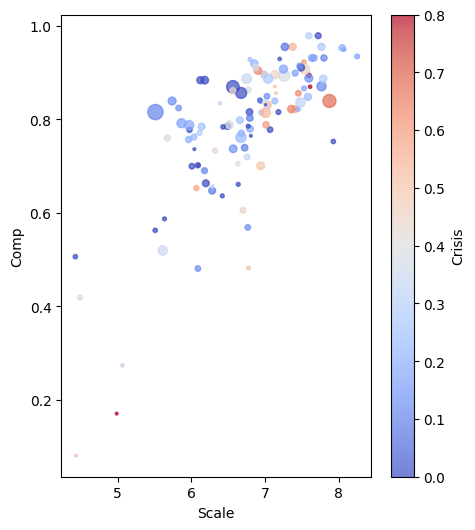

In [321]:
import matplotlib.pyplot as plt

dataset_plot = pt_dat_2
polity_group = pt_dat_2.groupby('PolityName')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale'].mean()
mean_crisis = polity_group['assassin'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]


v_max = mean_crisis.max()*0.8
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

In [322]:
import statsmodels.api as sm

x_cols = ['Scale','Comp']
y_col = 'assassin'
Xy = pt_dat_2[[y_col]+x_cols].dropna()
Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col].apply(int)

# linear_model = sm.OLS(y, X)
# result = linear_model.fit()

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
# print pvalues
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.543210
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               assassin   No. Observations:                 1174
Model:                          Logit   Df Residuals:                     1171
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Jan 2025   Pseudo R-squ.:                 0.03481
Time:                        13:40:14   Log-Likelihood:                -637.73
converged:                       True   LL-Null:                       -660.73
Covariance Type:            nonrobust   LLR p-value:                 1.024e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Scale          0.8310      0.129      6.465      0.000       0.579       1.083
Comp          -3.5318      0.

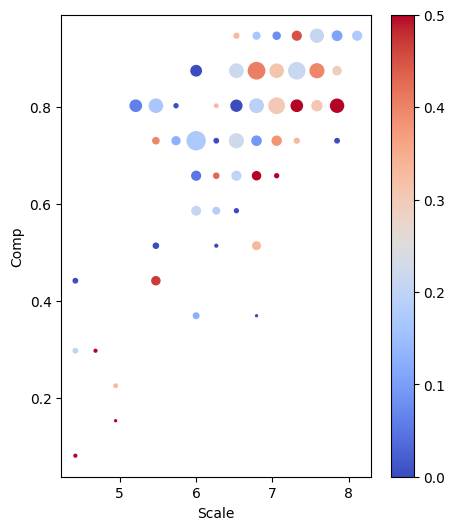

In [323]:
x_cols = ['Scale','Comp']
y_col = 'assassin'
Xy = pt_dat_2[[y_col]+x_cols].dropna()

x = Xy["Scale"].values
y = Xy["Comp"].values
z = Xy["assassin"].values

grid_size = 15

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()

fig, ax = plt.subplots(figsize=(5, 6))
x,y = np.meshgrid(x_bins, y_bins)
plt.scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=counts.T.values.flatten()*2, vmax = 0.5)
plt.colorbar()
plt.xlabel('Scale')
plt.ylabel('Comp')
# plt.title(crisis_vars)
plt.show()

Dataset loaded from ../datasets/PT_dataset_imputed.xlsx


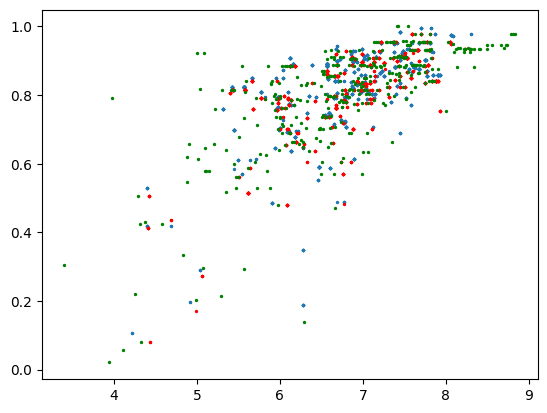

In [324]:
dataset_PT = TSD(file_path='../datasets/PT_dataset_imputed.xlsx')
plt.scatter(pt_dat.Scale,pt_dat.Comp,s = 2)
plt.scatter(pt_dat_2.Scale,pt_dat_2.Comp,s = 2,c='r')
plt.scatter(dataset_PT.scv_imputed.Scale_1,dataset_PT.scv_imputed.Comp,s = 2,c='g')

In [325]:
large_scale_pols = dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed['Scale_1']> 8.5].PolityName.unique()
large_scale_pols = [polities_df.loc[polities_df.PolID == pol,'polity_old_ID'].values[0] for pol in large_scale_pols]
dataset_PT.scv_imputed['old_pol_name'] = dataset_PT.scv_imputed.PolityName.apply(lambda x: polities_df.loc[polities_df.PolID == x,'polity_old_ID'].values[0])


Text(0.5, 1.0, 'New dataset')

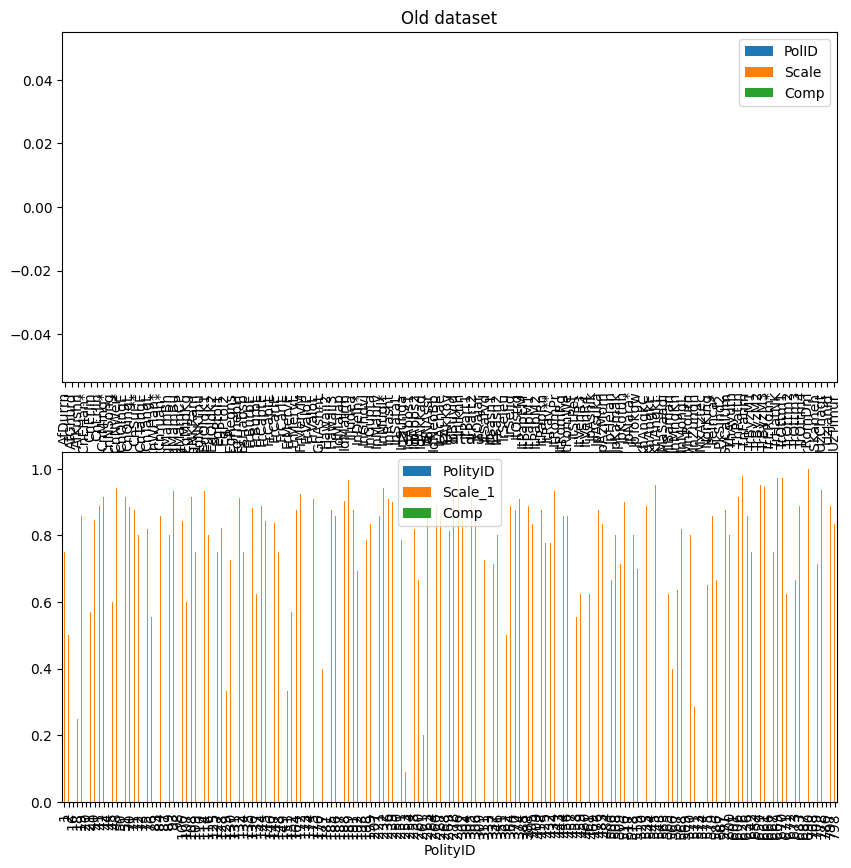

In [332]:
bars_old = pt_dat[['PolID','Scale', 'Comp']].groupby('PolID').apply(lambda x: x.isna().sum()/len(x))
bars_new = dataset_PT.scv_imputed[['PolityID','Scale_1', 'Comp']].groupby('PolityID').apply(lambda x: x.isna().sum()/len(x))

# plot bar charts
fig, ax = plt.subplots(2,1, figsize=(10, 10))
bars_old.plot(kind='bar', ax=ax[0])
bars_new.plot(kind='bar', ax=ax[1])
ax[0].set_title('Old dataset')
ax[1].set_title('New dataset')